<a href="https://colab.research.google.com/github/tarun2521/project2/blob/main/project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import necessary libraries

In [ ]:
!git clone https://github.com/tarun2521/project2.git
#!pip install tensorflow
!pip install pydot
!pip install graphviz
import pandas as pd
import keras
import tensorflow
import numpy as np
from tensorflow .keras.preprocessing.text import Tokenizer
from tensorflow .keras.preprocessing.sequence import pad_sequences
from tensorflow .keras.utils import to_categorical
from tensorflow .keras.layers import add
from tensorflow .keras.models import Model,load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow .keras.layers import Input,Dense,LSTM,Embedding,Dropout,Layer
from tensorflow .keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow .keras.preprocessing.image import load_img,img_to_array
from tensorflow .keras.applications import vgg16
import os
from tqdm import tqdm
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, LSTM, BatchNormalization, concatenate
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

Cloning into 'project2'...
remote: Enumerating objects: 8098, done.
remote: Total 8098 (delta 0), reused 0 (delta 0), pack-reused 8098 (from 1)
Receiving objects: 100% (8098/8098), 1.03 GiB | 25.63 MiB/s, done.
Updating files: 100% (8094/8094), done.


#### Dataset uploading

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import zipfile

# # Define the file path
# zip_file_path = "/content/drive/MyDrive/archive.zip"
# extract_to = "/content"

# # Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

# print("File unzipped successfully!")


In [ ]:
image_url='/content/project2/Images'

In [ ]:
url='/content/project2/captions.txt'
caption=pd.read_csv(url)
#caption.rename(columns={'image_name': 'image','comment': 'caption'}, inplace=True)
caption.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


#### Feature extraction using vgg16() and Normalizing the features

In [ ]:
model=vgg16.VGG16()
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
features={}
for image_name in tqdm(caption['image'].unique().tolist()):
    image=load_img(os.path.join(image_url,image_name),target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    feature = (feature - feature.mean()) / feature.std()
    image_id=image_name.split('.')[0]
    features[image_id]=feature


100%|██████████| 8091/8091 [10:01<00:00, 13.45it/s]


In [ ]:
import numpy as np

# Convert dictionary values to a numpy array
all_features = np.array(list(features.values()))

# Check statistics
print("Min value:", np.min(all_features))
print("Max value:", np.max(all_features))
print("Mean value:", np.mean(all_features))
print("Standard deviation:", np.std(all_features))


Min value: -0.79143476
Max value: 16.240019
Mean value: -1.364006e-10
Standard deviation: 1.0


In [ ]:
len(caption)

40455

#### Mapping each image with its set of captions and cleaning all the captions

In [ ]:
mapping={}
for i,row in caption.iterrows():
  image_id=row['image']
  caption=row['caption']
  image_id=image_id.split('.')[0]
  if image_id not in mapping:
    mapping[image_id]=[]
  mapping[image_id].append(caption)


In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
def clean(mapping):
  for key,captions in mapping.items():
    for i in range (len(captions)):
      caption=captions[i]
      caption=caption.lower()
      caption=caption.replace('\s+',' ')
      caption=caption.replace('[^A-Za-z]','')
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
      captions[i]=caption

In [ ]:
clean(mapping)
len(mapping)

8091

In [ ]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
all_captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas 

In [ ]:
len(all_captions)

40455

#### Tokenization of words present in the captions

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Limit vocabulary size to reduce overfitting
MAX_VOCAB_SIZE = 5000  # Limit vocabulary to top 6000 words

# Initialize the tokenizer with limited vocabulary
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<unk>")  # Use <unk> for out-of-vocabulary words

# Step 2: Fit the tokenizer on all captions
tokenizer.fit_on_texts(all_captions)

# Step 3: Get the vocabulary size (limited to MAX_VOCAB_SIZE)
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)  # Ensure it matches MAX_VOCAB_SIZE

# Step 4: Convert all captions to sequences
sequences = tokenizer.texts_to_sequences(all_captions)

# Step 5: Calculate the maximum caption length (ensure realistic bounds)
max_length = max(len(seq) for seq in sequences)
MAX_CAPTION_LENGTH = min(max_length, 20)  # Cap at 20 tokens for computational efficiency

# Step 6: Pad all sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=MAX_CAPTION_LENGTH, padding='post', truncating='post')

# Optional: Print summary
print(f"Vocabulary Size (after limiting): {vocab_size}")
print(f"Maximum Caption Length (capped): {MAX_CAPTION_LENGTH}")
print(f"Padded Sequences Shape: {padded_sequences.shape}")


Vocabulary Size (after limiting): 5000
Maximum Caption Length (capped): 20
Padded Sequences Shape: (40455, 20)


In [ ]:
# tokenizer=Tokenizer()
# tokenizer.fit_on_texts(all_captions)
# vocab_size=len(tokenizer.word_index)+1
# max_length=max(len(caption.split()) for caption in all_captions)

In [ ]:
print(vocab_size,max_length)

5000 35


#### Splitting the dataset into 90:10 ratio for training and testing

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

#### Developing Model Architecture

In [ ]:
# # encoder model
# # image feature layers
# inputs1 = Input(shape=(4096,), name="image")
# fe1 = Dropout(0.4)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)
# # sequence feature layers
# inputs2 = Input(shape=(max_length,), name="text")
# se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# se2 = Dropout(0.4)(se1)
# se3 = LSTM(256)(se2)

# # decoder model
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.2)(inputs1)
fe2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(fe1)
fe2 = BatchNormalization()(fe2)

# Sequence feature layers (Encoder for text)
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, return_sequences=False)(se2)
se3 = BatchNormalization()(se3)

# Decoder (Feature fusion)
decoder1 = concatenate([fe2, se3])  # Replacing add() with concatenate
decoder2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(decoder1)
decoder2 = BatchNormalization()(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Compile the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=1e-4)  # Smaller learning rate
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)         │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image (InputLayer)        │ (None, 4096)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 256)        │      1,280,000 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 4096)           │              0 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 35, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 35)             │              0 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        524,416 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ lstm[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 384)            │              0 │ batch_normalization[0… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         98,560 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256)            │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 5000)           │      1,285,000 │ batch_normalization_2… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,715,848 (14.17 MB)

 Trainable params: 3,714,568 (14.17 MB)

 Non-trainable params: 1,280 (5.00 KB)

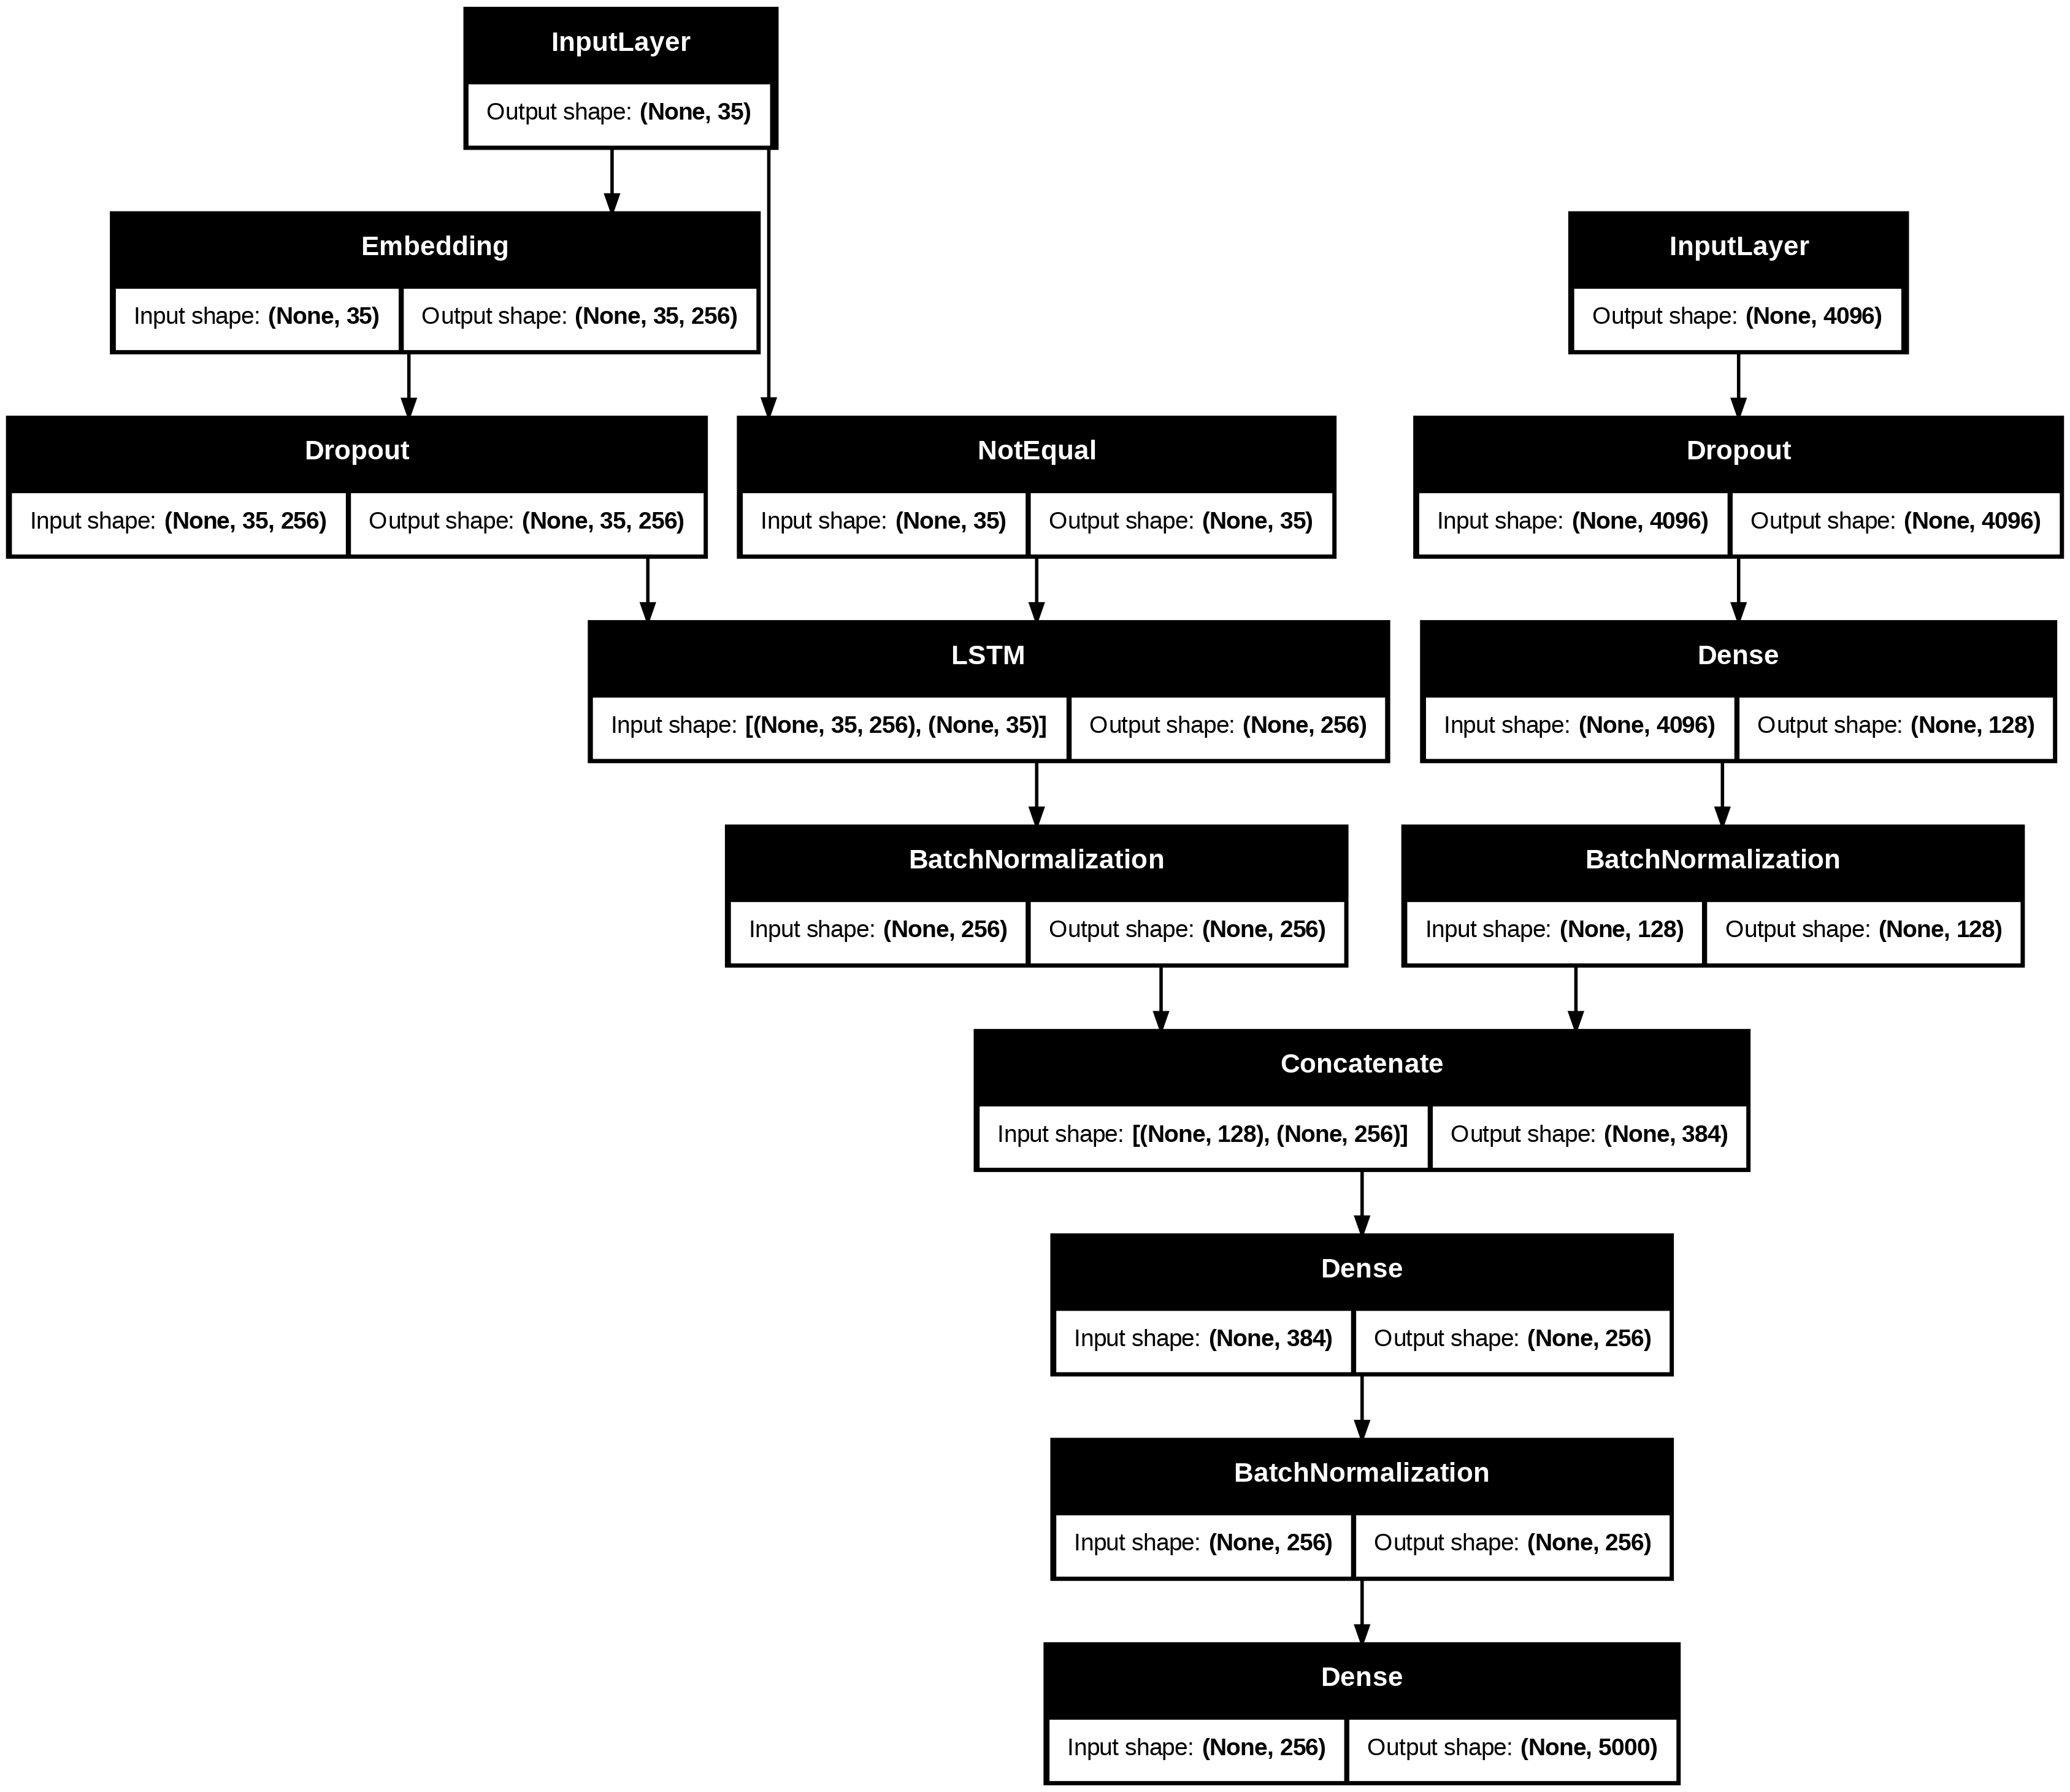

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

#### Model Training

In [ ]:
# epochs = 20
# batch_size = 32
# steps = len(train) // batch_size

# for i in range(epochs):
#     #create data generator
#     generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#    # fit for one epoch
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
# Checking the shape of one feature
image_id = list(features.keys())[0]  # Get the first image ID from the dictionary
feature = features[image_id]  # Get the feature for that image

# Check the shape of the feature
print(f"Shape of the feature for image {image_id}: {feature.shape}")


Shape of the feature for image 1000268201_693b08cb0e: (1, 4096)


In [ ]:
epochs = 30
batch_size = 32
model_name = "best_model.keras"  # Define your model save path

# Calculate steps per epoch for train and validation
train_steps = len(train) // batch_size  # Ensure integer division for steps
val_steps = len(test) // batch_size

# Define Callbacks

# ModelCheckpoint (Save best model based on validation loss)
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# EarlyStopping (Stop training if validation loss doesn't improve)
earlystopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
   # min_delta=0.001,  # Minimum change to consider improvement (optional)
    patience=3,
    verbose=1,
    restore_best_weights=True  # Restore weights of the best epoch
)

# ReduceLROnPlateau (Reduce learning rate when validation loss plateaus)
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_loss",
    mode="min",
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.00000001
)

# Create data generators (replace with your data_generator function)
# Example: Assuming train and test are numpy arrays
train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Fit the model with callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    verbose=1,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

# Proper session management (use tf.keras.backend.clear_session() in later TensorFlow versions)
if tensorflow.__version__.startswith('2'):  # Check TensorFlow version
    tensorflow.keras.backend.clear_session()
else:
    K.clear_session()  # Maintain compatibility with older versions

# Garbage collection (consider using a memory profiler for optimization)
import gc
gc.collect()

Epoch 1/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 12.8421
Epoch 1: val_loss improved from inf to 10.42163, saving model to best_model.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 224ms/step - loss: 12.8366 - val_loss: 10.4216 - learning_rate: 1.0000e-04
Epoch 2/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 8.4789
Epoch 2: val_loss improved from 10.42163 to 7.57007, saving model to best_model.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 218ms/step - loss: 8.4759 - val_loss: 7.5701 - learning_rate: 1.0000e-04
Epoch 3/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 6.0051
Epoch 3: val_loss improved from 7.57007 to 5.36812, saving model to best_model.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 221ms/step - loss: 6.0038 - val_loss: 5.3681 - learning_rate: 1.0000e-04
Epoch 4/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 4.9319
Epoch 4: val_loss improved from 5.36812 to 4.60760, saving model to best_model.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 221ms/step - loss: 4.9315 - val_

0

#### Plotting graph to show validation loss and training loss along saving the trained model



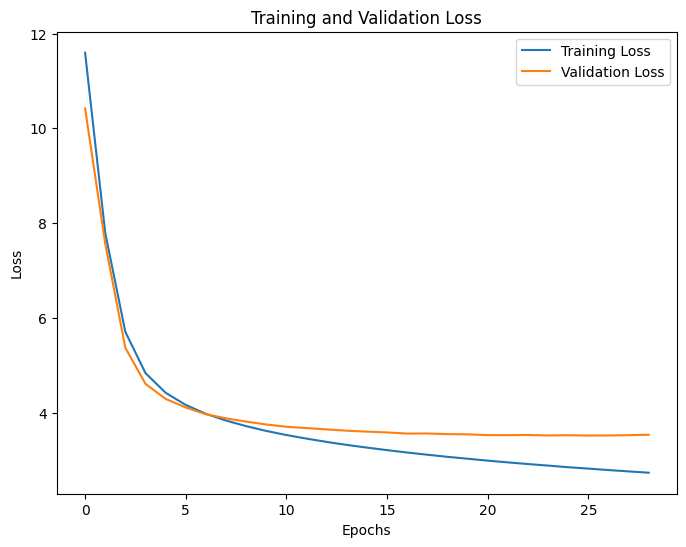

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model.save('best_model2.keras')

In [ ]:
with open('model_data.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data)

#### Sample caption genertaion

In [ ]:
def idx_to_word(integer,tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/project2/', "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq four wheeler jumping in an empty field endseq
startseq man on four wheeler is flying through the air endseq
startseq person is riding an orange atv in large empty field endseq
startseq man jumping with all terrain vehicle endseq
startseq man on an atv catching air endseq
--------------------Predicted--------------------
startseq man is riding an atv through field endseq


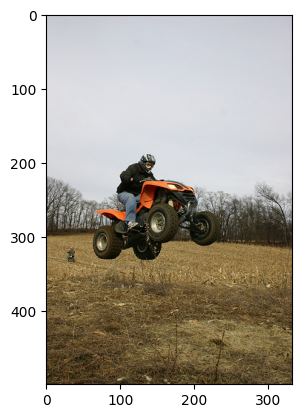

In [ ]:
generate_caption('109823395_6fb423a90f.jpg')

In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,
                  outputs=vgg_model.layers[-2].output)

In [ ]:
image_path = '/content/19-lamborghini-iron-lynx-lambo.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

#### Metric evaluation of the trained model

BLEU score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# Initialize lists to hold actual and predicted captions
actual, predicted = list(), list()

# Loop through each test image
for key in tqdm(test):
    # Get actual captions for the image
    captions = mapping[key]
    # Predict the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # Split captions into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # Append to the lists
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate and print BLEU scores after all predictions are made
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


100%|██████████| 810/810 [07:14<00:00,  1.87it/s]


BLEU-1: 0.579664
BLEU-2: 0.352686


ROUGE-L Score

In [ ]:
! pip install rouge_score
from rouge_score import rouge_scorer
# Initialize a scorer for ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

# Initialize list to hold ROUGE scores
rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

# Loop through each test image
for key in tqdm(test):
    # Get actual captions for the image
    captions = mapping[key]
    # Predict the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    # Calculate ROUGE scores for each predicted and actual caption
    for caption in captions:
        score = scorer.score(caption, y_pred)
        rouge_scores['rouge1'].append(score['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(score['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(score['rougeL'].fmeasure)

# Calculate and print the average ROUGE scores
avg_rouge1 = sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1'])
avg_rouge2 = sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2'])
avg_rougeL = sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL'])

print(f"Average ROUGE-1 score: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 score: {avg_rouge2:.4f}")
print(f"Average ROUGE-L score: {avg_rougeL:.4f}")

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=e209be56d20511c06e489f4e64ef178530e5f4ec0c3fe0f4b318033178839bcd
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


100%|██████████| 810/810 [07:16<00:00,  1.86it/s]

Average ROUGE-1 score: 0.3674
Average ROUGE-2 score: 0.0796
Average ROUGE-L score: 0.3576
